In [143]:
import os
import shutil

import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import geopandas as gpd
from shapely.ops import unary_union
import alphashape

class ProvedArea:
    def __init__(self):

        #Store the required file paths from GitHub
        header_path = 'ComboCurve Header Example.csv'
        forecast_parameters_path = 'ComboCurve Forecast Parameter Example.csv'
        #header_path = "https://raw.githubusercontent.com/TravisSalomaki/ProvedArea/main/ComboCurve%20Header%20Example.csv?token=GHSAT0AAAAAACJLPMOQ4HYTJEIUK7PVAND2ZJYM4PA"
        #forecast_parameters_path = 'https://raw.githubusercontent.com/TravisSalomaki/ProvedArea/main/ComboCurve%20Forecast%20Parameter%20Example.csv?token=GHSAT0AAAAAACJLPMOQYD4PCMSPFFODC3PCZJYM3CA'

        #Read in forecast_parameters file & perform a quick data cleaning
        forecast_parameters = pd.read_csv(forecast_parameters_path,usecols=['Well Name',
                                                                            'INPT ID',
                                                                            'EUR (MBBL, MMCF)',
                                                                            'EUR/FT (BBL/FT, MCF/FT)'])
        forecast_parameters.drop_duplicates(inplace = True)
        forecast_parameters.reset_index(inplace = True, drop = True)
        forecast_parameters['INPT ID'] = forecast_parameters['INPT ID'].astype(str)

        #Read in the header file & format the INPT column
        headers = pd.read_csv(header_path,usecols=["INPT ID","Surface Latitude",'Surface Longitude','Perf Lateral Length'])
        headers['INPT ID'] = headers['INPT ID'].astype(str)

        #Merge forecast_parameters with headers to create a DataFrame containing both header info plus forecast parameter info
        df = pd.merge(left = forecast_parameters, right = headers, how = 'inner', on = 'INPT ID')

        #Create a GeoPandas DataFrame and define the active geometry as the Surface Lat Long points
        self.gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df['Surface Longitude'], df['Surface Latitude']))

        #Instantiates the radii list
        self.radii_list = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0])

        #Instantiates the mask list
        self.mask_list = []

        #Sets the first radii_level
        self.radii_level = 1


    def calculate_p10_p90_ratio(self, x):
        """
        INPUTS:  X [array]
        OUTPUTS: p10/p90 ratio
        """
        p10 = np.quantile(x, 0.9)
        p90 = np.quantile(x, 0.1)
        return p10/p90

    def calculate_mean(self, x):
        """
        INPUTS:  X [array]
        OUTPUTS: mean(X)
        """
        return np.mean(x)
    
    def get_sample_size(self, ratio):
        """
        INPUTS:  ratio [float] -> p10/p90 ratio
        OUTPUTS: int corresponding to the minimum sample size required to yield a statistically 
                 accurate distribution of >90% as defined by SPEE Monograph 3
        """
        if ratio <3:
            return 15
        elif 3 <= ratio < 4:
            return 35
        elif 4 <= ratio <5:
            return 60
        elif 5 <= ratio <6:
            return 75
        elif 6<= ratio <8:
            return 100
        elif 8<= ratio <10:
            return 130
        elif 10<= ratio <15:
            return 170
        else:
            return 200 
        
    def generate_anchors(self):
        #PURPOSE: Randomly samples the analog wells to generate N anchor wells using the sample count provided by get_sample_size()
        p10_p90_ratio = self.calculate_p10_p90_ratio(self.gdf['EUR/FT (BBL/FT, MCF/FT)'])
        sample_size = self.get_sample_size(p10_p90_ratio)
        self.anchors_idx = np.random.choice(self.gdf.index,sample_size, replace = False)
        return None
    
    def generate_radii(self, radius):
        '''
        INPUTS:  radius [float or int]
        OUTPUTS: buffer object [array of Polygons]

        Given a radius, the function generates a buffer object surrounding all the analog points
        NOTE, since the given geometry units are in coordinates, we must convert the lat/long degrees into 
        miles by dividing by 69.
        '''
        return self.gdf.geometry.buffer(radius/69)
        
    def generate_boundary(self, radii):
        #NEED ERROR HANDLING ON THE BUFFER
        '''
        INPUTS:  buffer radii object [array of Polygons]
        OUTPUTS: Merged multipolygon of all overlapping anchor buffers [MultiPolygon]

        We index the buffer object to access only the anchor well locations, then join them all using the unary_union function and then
        wrap that all in a GeoSeries.
        '''
        return gpd.GeoSeries(unary_union(radii[self.anchors_idx]))

    def generate_mask(self,boundary, radii_level):
        '''
        INPUTS:  boundary [MultiPolygon] from the generate_boundary() funciton
                 radii_level [int] corresponding to which concentric ring layer we are on
        OUTPUTS: mask [Boolean Array] giving you the wells in the concentric ring layer 
                 that are not anchors and not in the previous ring layer(s)
        '''
        
        if radii_level == 1:
            return (self.gdf.geometry.within(boundary[0]) & pd.Series(~self.gdf.index.isin(self.anchors_idx)))
        elif radii_level == 2:
            return (self.gdf.geometry.within(boundary[0]) & pd.Series(~self.gdf.index.isin(self.anchors_idx))) & ~self.mask_list[0]
        elif radii_level > 2:
            return (self.gdf.geometry.within(boundary[0]) & pd.Series(~self.gdf.index.isin(self.anchors_idx))) & self.aggregate_ands(self.mask_list)
        else:
            pass
    
    def aggregate_ands(self, masks):    
        '''
        INPUTS:  masks [list]
        OUTPUTS: aggreagated_masks [boolean array] giving you the aggregate list of wells already used by other radii layers
        
        Instaniates 'y' as all the wells that are NOT in r1 nor r2
        If 'masks' has more than two items, iterate through the remainder and redefine 'y' as everything NOT in the remainder
        of the radii
        '''
        aggregated_masks = ~masks[0] & ~masks[1]
        if len(masks) > 2:
            for i in range(len(masks) - 2):
                aggregated_masks = aggregated_masks & ~masks[i+2]
        return aggregated_masks
    
    def update_radii_list(self, radii_level):

        #Increases the distance of all radii from the current radii_level to the end up by 5%
        self.radii_list[radii_level:] = self.radii_list[radii_level:] * 1.05
        return None

    def iterate_masks(self):
        kill_swtich = 1
        while kill_swtich == 1:
            
            print(f'Radii Level: {self.radii_level}')
            print(f'Radii Distance: {round(self.radii_list[self.radii_level-1],2)}')
            
            #Generate an initial mask attempt
            radii = self.generate_radii(self.radii_list[self.radii_level - 1])
            boundary = self.generate_boundary(radii)
            mask = self.generate_mask(boundary, self.radii_level)
            update_count = 0
            
            """
            If the mask contains less than 50 wells, increase the radii distance and try again until you've either hit greater than 
            50 wells or you've attempted to increase the radii 10 times. 
            Else, just append the created mask to the mask_list.
            """

            while mask.sum() <= 50:
                if update_count == 10:
                    print('Cannot increase radii further.')
                    kill_swtich = 0
                    break
                self.update_radii_list(self.radii_level-1)
                update_count += 1
                
                mask = self.generate_mask(self.generate_boundary(self.generate_radii(self.radii_list[self.radii_level-1])),self.radii_level)

            print(f'Number of wells in current radii mask: {mask.sum()}\n')
            self.mask_list.append(mask)

            #Increment the radii_level parameter
            self.radii_level+=1

    def plot_comparisons(self):
        avgs = []
        counts = []

        for i in self.mask_list:
            counts.append(len(self.gdf[i]))
            avgs.append(self.gdf[i]['EUR/FT (BBL/FT, MCF/FT)'].mean())

        analog_mean = self.gdf['EUR/FT (BBL/FT, MCF/FT)'].mean()
        anchor_mean = self.gdf.loc[self.anchors_idx]['EUR/FT (BBL/FT, MCF/FT)'].mean()

        avgs.insert(0,analog_mean)
        counts.insert(0,len(self.gdf['EUR/FT (BBL/FT, MCF/FT)']))

        avgs.insert(1,anchor_mean)
        counts.insert(1,len(self.anchors_idx))

        fig,ax = plt.subplots(1,2,figsize = [15,5])
        xticks = ['Analog Wells','Anchor Wells'] + [ 'r' + str(i) for i in range(1,len(self.mask_list)+1)]
        ax[0].set_xticks(np.arange(len(self.mask_list)+2),labels = xticks,rotation = 45)
        ax[1].set_xticks(np.arange(len(self.mask_list)+2),labels = xticks,rotation = 45)
        ax[0].set_ylabel('EUR/FT')
        ax[1].set_ylabel('Wells')

        ax[0].plot(avgs,label = 'EUR/FT Avg')
        ax[1].plot(counts,label = 'Well Count',color = 'green')
        ax[0].hlines(xmin = 0,xmax=len(self.mask_list)+1, y = 0.9*analog_mean,linestyles='dashed',color = 'black')

        ax[0].scatter(np.arange(len(self.mask_list)+2),avgs,color ='black')
        ax[1].scatter(np.arange(len(self.mask_list)+2),counts,color = 'black')

        ax[0].legend()
        ax[1].legend()

        ax[0].grid()
        ax[1].grid()
        return
    
    def plot_wells(self):
        fig,ax = plt.subplots(figsize=[12,12])
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        self.gdf.plot(label = 'Analog Wells',ax =ax,color = 'black')

        #Radiis 
        for idx,i in enumerate(reversed(self.radii_list[0:self.proved_radii+1])):
            self.generate_boundary(self.generate_radii(i)).plot(ax=ax,alpha = np.linspace(0.2,1,self.proved_radii+1)[idx],color = 'grey')

        #Boundaries
        for idx,x in enumerate(self.mask_list):
            self.gdf[self.mask_list[idx]].plot(label = f'r{idx+1} wells',ax=ax)

        ax.legend()

    def plot_proved_areas(self):
        fig,ax = plt.subplots(figsize = [13,17])
        self.generate_boundary(self.generate_radii(self.radii_list[self.proved_radii])).plot(ax=ax,alpha = 1,color = 'lightblue')
        for i in self.proved_areas:
            gpd.GeoSeries(i).plot(ax=ax,alpha = 0.8,color = 'darkblue')
        self.gdf.plot(ax=ax,c= 'black',label = 'Analog Wells')
        self.gdf.loc[self.anchors_idx].plot(ax=ax,c='red',label= 'Anchor Wells',alpha = 0.8)

        legend_elements = [Line2D([0],[0],marker = 'o',color = 'w',markerfacecolor='black',label = 'Analog Wells',markersize= 8),
                        Line2D([0],[0],marker = 'o',color = 'w',markerfacecolor='red',label = 'Anchor Wells',markersize= 8),
                        Patch(facecolor='lightblue',edgecolor= 'w',label='Proved Radii'),
                        Patch(facecolor='blue',edgecolor='w',label= 'Proved Area')
                        ]
        ax.legend(handles = legend_elements)
        ax.grid()
        ax.set_xlabel("Longitude")
        ax.set_ylabel('Latitude')

    def compare_masks(self):
        print(f'90% Analog Mean: {0.9*self.analog_mean}')
        proved_radii = 0
        for i,m in enumerate(self.mask_list):
            mask_mean = self.gdf[m]['EUR/FT (BBL/FT, MCF/FT)'].mean()
            print(f'r{i+1} mean: {mask_mean }')
            if mask_mean < (0.9 *self.analog_mean):
                proved_radii = i-1
                break
            else:
                proved_radii = i
        return proved_radii

    def generate_proved_areas(self):
        #Create empty list to store the proved polygons in 
        self.proved_areas = []

        #After running the main code we finally know what radii level is considered 'proved' 
        #With that, we index into the radii_list to pull the corresponding distance, then we generate radii polygons for all of our anchor wells, and then aggregate them all together into a list of multi-polygons
        #From here, we iterate through the list of multi-polygons to see which analog wells exist within them (pts)
        #Lastly, we create an alphashape or a concave hull from the pts and store that in the shapes list
        for i in list(self.generate_boundary(self.generate_radii(self.radii_list[self.proved_radii]))[0].geoms):
            pts = self.gdf[self.gdf.geometry.within(i)]
            self.proved_areas.append(alphashape.alphashape(pts,15))
    
    def export_shapefiles(self):
        folder_name = input("What would you like to name the ShapeFile?: ")
        folder_path = os.getcwd()+'\\'+folder_name
        try:
            os.mkdir(folder_path)
        except FileExistsError:
            pass
        shapefile_gdf = gpd.GeoDataFrame(geometry=self.proved_areas,crs = 'EPSG:4326')
        shapefile_gdf = shapefile_gdf[shapefile_gdf.geom_type == 'Polygon']
        shapefile_gdf.to_file(folder_path)
        os.remove(folder_path + '\\' + folder_name +'.cpg')
        shutil.make_archive(folder_name, 'zip', folder_path)

    def main(self):
        #Checks if the p10/p90 ratio of the analog wells is <10:
        if self.calculate_p10_p90_ratio(self.gdf["EUR/FT (BBL/FT, MCF/FT)"]) < 10:
            
            #Generate Anchor Points
            try:
                self.generate_anchors()
            except ValueError:
                print("Unable to generate sufficient anchor points as input wellset population count is less than the calculated sample size defined by the analog p10/90 ratio.")

            #Check if the anchor points mean value is greater than 0.9*mean(analog wells)
            self.analog_mean = self.calculate_mean(self.gdf["EUR/FT (BBL/FT, MCF/FT)"])
            self.anchor_mean = self.calculate_mean(self.gdf.loc[self.anchors_idx]["EUR/FT (BBL/FT, MCF/FT)"])
            
            if self.anchor_mean >= 0.9*self.analog_mean:
                self.iterate_masks()
                self.proved_radii = self.compare_masks()
                #self.plot_comparisons()
                try:
                    self.generate_proved_areas()
                except AttributeError:
                    pass
                self.proved_area_realizations.append(self.proved_areas)
                #self.plot_proved_areas()
                pass
            else:
                print('Anchor point mean EUR/FT is too low. Try re-intializing your Anchor points.')
                return None
        else:
            print('P10/P90 ratio of analogous wellset is greater than 10. Please upload a better wellset.')
            return

    def driver(self):
        self.proved_area_realizations = []
        for i in range(100):
            self.main()
            self.radii_list = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0])
            self.mask_list = []
            self.radii_level = 1
        return None
    


In [144]:
y = ProvedArea()
y.driver()

Anchor point mean EUR/FT is too low. Try re-intializing your Anchor points.
Anchor point mean EUR/FT is too low. Try re-intializing your Anchor points.
Radii Level: 1
Radii Distance: 1.0
Number of wells in current radii mask: 133

Radii Level: 2
Radii Distance: 2.0
Number of wells in current radii mask: 78

Radii Level: 3
Radii Distance: 3.0
Number of wells in current radii mask: 89

Radii Level: 4
Radii Distance: 4.0
Number of wells in current radii mask: 77

Radii Level: 5
Radii Distance: 5.0
Number of wells in current radii mask: 55

Radii Level: 6
Radii Distance: 6.95
Cannot increase radii further.
Number of wells in current radii mask: 44

90% Analog Mean: 72.83557800575426
r1 mean: 73.67151700105805
r2 mean: 95.1612029130476
r3 mean: 78.35255972458559
r4 mean: 77.22250692393727
r5 mean: 87.21872507742587
r6 mean: 88.76228841848095
Radii Level: 1
Radii Distance: 1.0
Number of wells in current radii mask: 126

Radii Level: 2
Radii Distance: 2.0
Number of wells in current radii mask

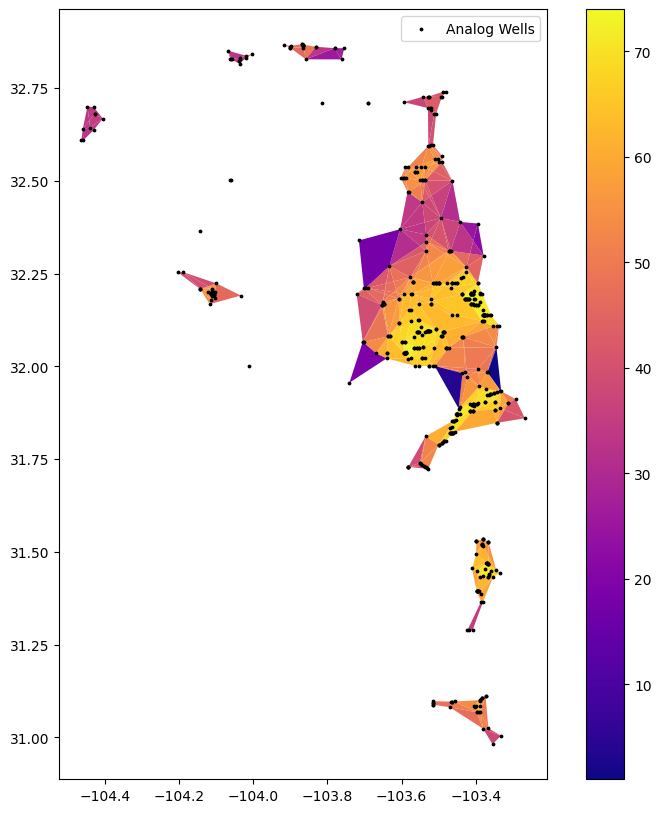

In [151]:
flat_list = [item for sublist in y.proved_area_realizations for item in sublist]
all = gpd.GeoDataFrame(geometry = flat_list)
all = all[all.geom_type != 'Point']

def count_overlapping_features(gdf):
    #generating all of the split pieces
    import shapely
    bounds = gdf.geometry.exterior.unary_union
    new_polys = list(shapely.ops.polygonize(bounds))
    new_gdf = gpd.GeoDataFrame(geometry=new_polys)
    new_gdf['id'] = range(len(new_gdf))

    #count overlapping by sjoin between pieces centroid and the input gdf 
    new_gdf_centroid = new_gdf.copy()
    new_gdf_centroid['geometry'] = new_gdf.centroid
    overlapcount = gpd.sjoin(new_gdf_centroid,gdf)
    overlapcount = overlapcount.groupby(['id'])['index_right'].count().rename('count').reset_index()
    out_gdf = pd.merge(new_gdf,overlapcount)
    return out_gdf

overlaps = count_overlapping_features(all)
overlaps = overlaps.sort_values('count',ascending = False).reset_index(drop = True)
fig,ax = plt.subplots(figsize = [10,10])
im = overlaps.plot(ax=ax,column = 'count',legend = True,cmap = 'plasma')
y.gdf.plot(ax=ax,color = 'black',label = 'Analog Wells',markersize = 3)
ax.legend()
